In [22]:
%pip install inference
%pip install imagecodecs

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 8.4 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install inference

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install python-dotenv
%pip install roboflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import glob
ddr_tr = glob.glob("/home/ayang/CMAC-model/lesion_segmentation/train/image/*.jpg")
ddr_tr.sort()
ddr_v = glob.glob("/home/ayang/CMAC-model/lesion_segmentation/valid/image/*.jpg")
ddr_v.sort()
ddr_tst = glob.glob("/home/ayang/CMAC-model/lesion_segmentation/test/image/*.jpg")
ddr_tst.sort()


In [2]:
ddr_array_t = np.array(ddr_tr)
ddr_array_v = np.array(ddr_v)
ddr_array_tst = np.array(ddr_tst)

In [ ]:
import roboflow
#A key for optic disc segmentation model is required here
rf = roboflow.Roboflow(api_key="INSERT KEY HERE")

project = rf.workspace().project("my-first-project-vuhis")

model = project.version("1").model

loading Roboflow workspace...
loading Roboflow project...


In [15]:
import os
import base64
import numpy as np
import cv2

# ensure output directory exists
os.makedirs("OD", exist_ok=True)

def decode_mask(result):
    # The mask is a PNG stored as base64 → decode to bytes
    b64 = result["predictions"][0]["segmentation_mask"]
    png_bytes = base64.b64decode(b64)

    # Convert PNG bytes → numpy array of bytes
    png_array = np.frombuffer(png_bytes, np.uint8)

    # Decode PNG into an image
    mask = cv2.imdecode(png_array, cv2.IMREAD_UNCHANGED)
    # Ensure single-channel
    if mask.ndim == 3:
        mask = mask[:, :, 0]
    return mask

# loop through images
for img_path in ddr_array_tst:
    # make prediction
    pred = model.predict(img_path, confidence=0.9).json()
    print(pred)

    # decode mask
    mask = decode_mask(pred)

    # filename: take the ORIGINAL image filename but change extension to .tif
    filename = os.path.basename(img_path)              # e.g. "001.jpg"
    out_name = os.path.splitext(filename)[0] + ".tif"  # "001.tif"

    out_path = os.path.join("OD", out_name)

    # save mask as TIFF
    cv2.imwrite(out_path, mask)

    print("Saved:", out_path)

{'predictions': [{'segmentation_mask': 'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAAAAADRE4smAAACZUlEQVR4nO3dUU7DMBBF0RSx/y3DB/wgmjSROn4TzTkLoIi5dhwLwbYBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACQ8Uh/A/z6mcRX5mMJ+zuGlRUIoIEnQ1jWgADidkawKIGPNR/Drr0luGhp2gGyjn7+S/YAO0DU4fpbsjgF0NiKAgSQ9GrCCwoQQGv1BQgg6MR4ywsQwHACyDm1uqu3AAF0V1yAAGJ63MEJIOX0/GtDEUB/pQUIIOTKVCsLEMAdFBYggIyLI60rQAD3UFaAAIYTQESPO4BtE8BtVCUjgOEEMJwA7qLoGSCA4QSQ0OclQADTCWA4AQwngOEEkLD8z0DsE8BwAhhOAMMJIKLPIUAAwwkgo80WIIC7KEpGAMMJIOTqgq56ZghgOAGkXFvSZYdGAcT0eBEQQM6FAupiEUBQhz1AAElnCygsRQBR5yZbuVN8Fn5t3qL2QdHoF5RnejWA6nOCAOIOR1B+TnQGiDuacf17ggDy9qe84D3RI6CFp2NYck0ggCb+D2LNNZEA2sj870ABdPPocUUMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABc8g2DXCB0HW3sYwAAAABJRU5ErkJggg==', 'class_map': {'0': 'background', '1': 'Optic Disc', '2': 'obj

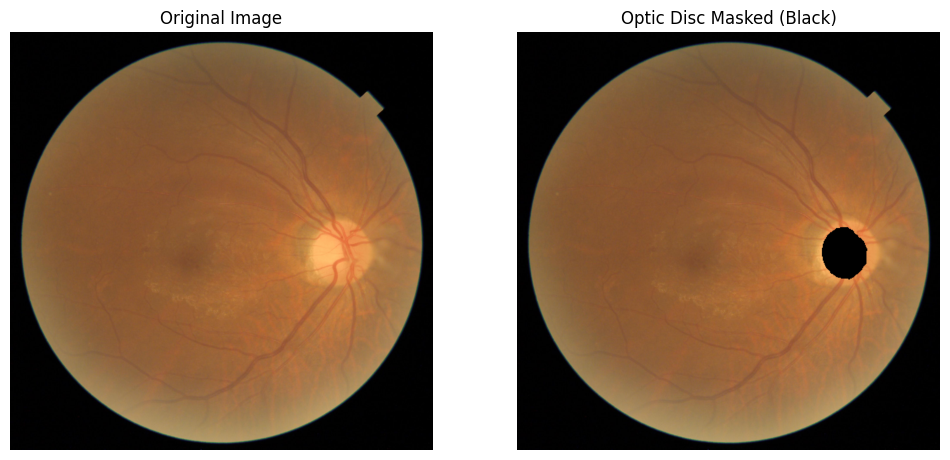

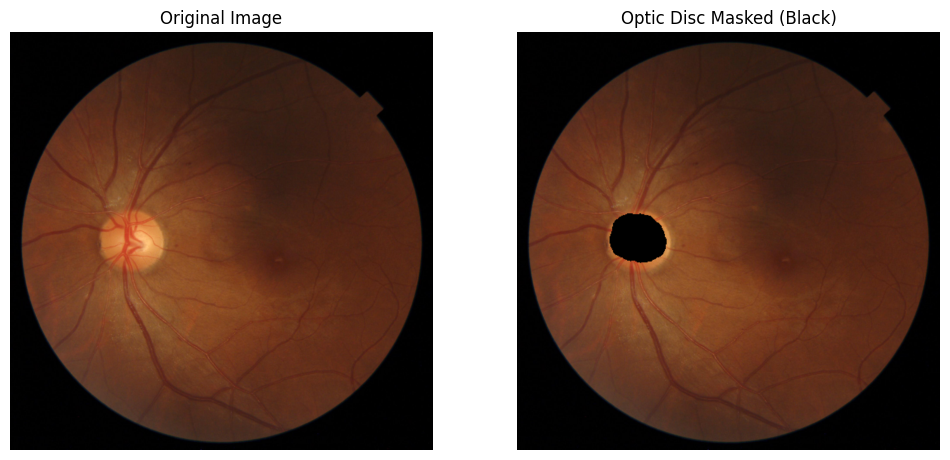

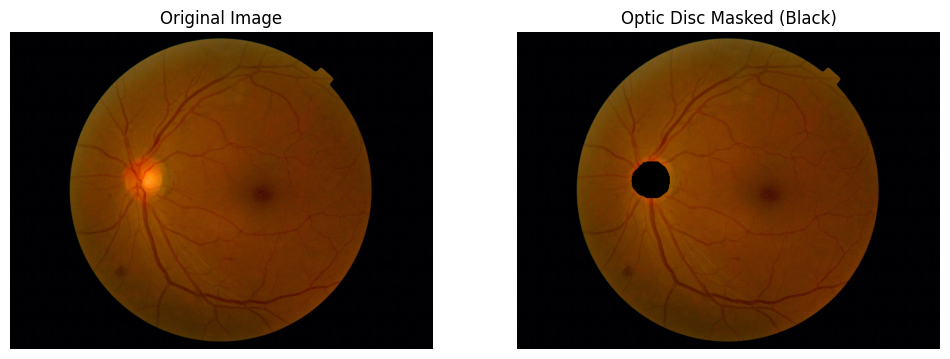

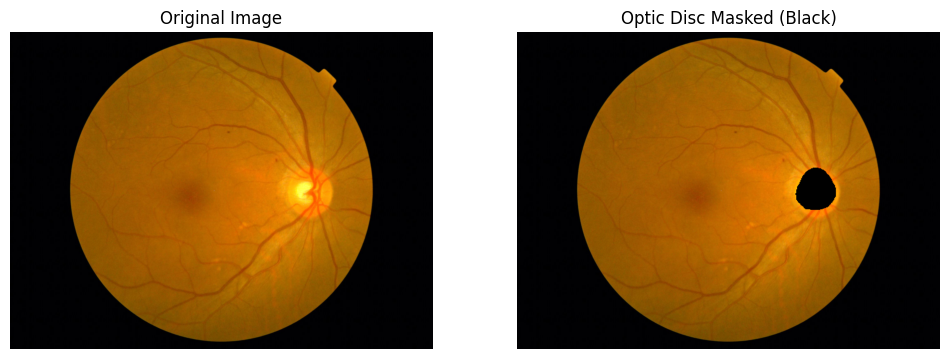

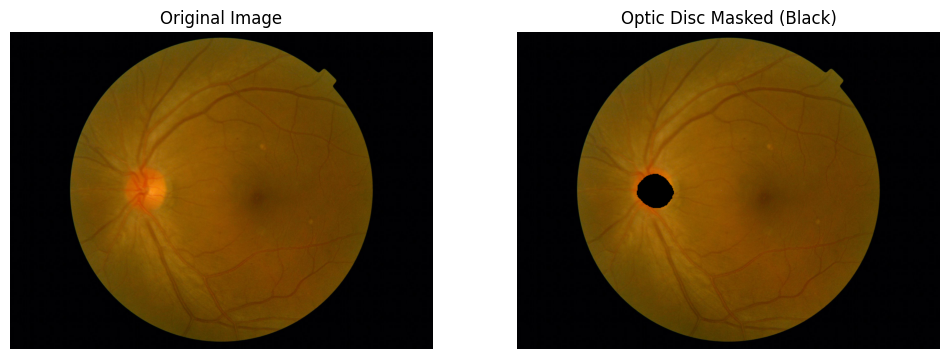

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_black_mask(image_path, mask_dir="lesion_segmentation/train/label/OD"):
    # Load original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    # Load mask
    base = os.path.splitext(os.path.basename(image_path))[0]
    mask_path = os.path.join(mask_dir, base + ".tif")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print("Missing mask:", mask_path)
        return

    # Resize mask to original image size
    if mask.shape != (H, W):
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)

    # ---- Create black overlay ----
    # For optic disc, the class ID is usually 1 (check your class_map)
    # Set pixels of the optic disc to 0 in the overlay image
    # Here we assume the mask has value 1 for optic disc
    masked_img = img.copy()
    masked_img[mask == 1] = 0  # black out the optic disc

    # ---- Show ----
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(masked_img)
    plt.title("Optic Disc Masked (Black)")
    plt.axis("off")
    plt.show()




for p in ddr_tr[5:10]:  # show first 5
    visualize_black_mask(p)